### Requirements

In [1]:
# %pip install -r requirements.txt

### Dependencies

In [2]:
import os
import random
import torch # type: ignore
from torchvision import transforms as tvt # type: ignore
from torch.utils.data import Dataset, DataLoader # type: ignore
from PIL import Image # type: ignore
import csv
import pandas as pd # type: ignore
import re
import itertools
import json
import numpy as np # type: ignore

# from pathlib import Path    # use this maybe for better cross-platform dependencies

os.environ["PYTHONHASHSEED"] = "42"
random.seed(1997)
torch.manual_seed(1997)
np.random.seed(1997)

### Global variables

In [3]:
# All CVR tasks
ALL_TASKS = {
    # elementary
    0: "task_shape",
    1: "task_pos",
    2: "task_size",
    3: "task_color",
    4: "task_rot",
    5: "task_flip",
    6: "task_count",
    7: "task_inside",
    8: "task_contact",
    # compositions
    9: "task_sym_rot",
    10: "task_sym_mir",
    11: "task_pos_pos_1",
    12: "task_pos_pos_2",
    13: "task_pos_count_2",
    14: "task_pos_count_1",
    15: "task_pos_pos_4",
    16: "task_pos_count_3",
    17: "task_inside_count_1",
    18: "task_count_count",
    19: "task_shape_shape",
    20: "task_shape_contact_2",
    21: "task_contact_contact_1",
    22: "task_inside_inside_1",
    23: "task_inside_inside_2",
    24: "task_pos_inside_3",
    25: "task_pos_inside_1",
    26: "task_pos_inside_2",
    27: "task_pos_inside_4",
    28: "task_rot_rot_1",
    29: "task_flip_flip_1",
    30: "task_rot_rot_3",
    31: "task_pos_pos_3",
    32: "task_pos_count_4",
    33: "task_size_size_1",
    34: "task_size_size_2",
    35: "task_size_size_3",
    36: "task_size_size_4",
    37: "task_size_size_5",
    38: "task_size_sym_1",
    39: "task_size_sym_2",
    40: "task_color_color_1",
    41: "task_color_color_2",
    42: "task_sym_sym_1",
    43: "task_sym_sym_2",
    44: "task_shape_contact_3",
    45: "task_shape_contact_4",
    46: "task_contact_contact_2",
    47: "task_pos_size_1",
    48: "task_pos_size_2",
    49: "task_pos_shape_1",
    50: "task_pos_shape_2",
    51: "task_pos_rot_1",
    52: "task_pos_rot_2",
    53: "task_pos_color_1",     # NOTE: we changed the name of the task from "task_pos_col_1" to "task_pos_color_1" compared to the original CVR dataset
    54: "task_pos_color_2",     # NOTE: we changed the name of the task from "task_pos_col_2" to "task_pos_color_2" compared to the original CVR dataset
    55: "task_pos_contact",
    56: "task_size_shape_1",
    57: "task_size_shape_2",
    58: "task_size_rot",
    59: "task_size_inside_1",
    60: "task_size_contact",
    61: "task_size_count_1",
    62: "task_size_count_2",
    63: "task_shape_color",
    64: "task_shape_color_2",
    65: "task_shape_color_3",
    66: "task_shape_inside",
    67: "task_shape_inside_1",
    68: "task_shape_count_1",
    69: "task_shape_count_2",
    70: "task_rot_color",
    71: "task_rot_inside_1",
    72: "task_rot_inside_2",
    73: "task_rot_count_1",
    74: "task_color_inside_1",
    75: "task_color_inside_2",
    76: "task_color_contact",
    77: "task_color_count_1",
    78: "task_color_count_2",
    79: "task_inside_contact",
    80: "task_contact_count_1",
    81: "task_contact_count_2",
    82: "task_size_color_1",
    83: "task_size_color_2",
    84: "task_color_sym_1",
    85: "task_color_sym_2",
    86: "task_shape_rot_1",
    87: "task_shape_contact_5",
    88: "task_rot_contact_1",
    89: "task_rot_contact_2",
    90: "task_inside_sym_mir",
    91: "task_flip_count_1",
    92: "task_flip_inside_1",
    93: "task_flip_inside_2",
    94: "task_flip_color_1",
    95: "task_shape_flip_1",
    96: "task_rot_flip_1",
    97: "task_size_flip_1",
    98: "task_pos_rot_3",
    99: "task_pos_flip_1",
    100: "task_pos_flip_2",
    101: "task_flip_contact_1",
    102: "task_flip_contact_2",
}

# Elementary tasks (tasks 0 to 8)
ELEMENTARY_TASKS = {k: ALL_TASKS[k] for k in range(9)}

# Compositions tasks (tasks 9 to 102)
COMPOSITE_TASKS = {k: ALL_TASKS[k] for k in range(9, 103)}

# Task name to task id dict
ALL_TASKS_NAME_TO_ID = {v: k for k, v in ALL_TASKS.items()}

In [4]:
# Create a json file that contains a dict that maps a task name to an id (positive integer)
# This is useful to later create a task embedding to be used by a model when making a prediction. Some simple ICL.
def create_task_name_to_id_dict(task_name_to_id_path):
    task_name_to_id = {v: k for k, v in ALL_TASKS.items()}
    with open(task_name_to_id_path, "w") as f:
        json.dump(task_name_to_id, f, indent=4)

final_datasets_folder = "./final_datasets"
if not os.path.exists(final_datasets_folder):
    os.makedirs(final_datasets_folder)

create_task_name_to_id_dict(f"./{final_datasets_folder}/CVR_task_name_to_id.json")

### Generation of CVR Data

In [5]:
GENERATE_ORIGINAL_DATA = False

IMG_SIZE = 128

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
if GENERATE_ORIGINAL_DATA:

    import generate_cvr_data

    # Parameters
    train_size = 10000  # originally: 10000
    val_size = 500  # originally: 500
    test_size = 1000    # originally: 1000
    test_gen_size = 1000    # originally: 1000
    image_size = IMG_SIZE # originally: 128
    seed = 1997
    data_dir = f"./generated_data_{image_size}x{image_size}"

    # Tasks to generate
    elem_tasks_considered = ["task_pos", "task_rot", "task_count", "task_color"]
    comp_tasks_considered = ["task_rot_rot_1", "task_count_count", "task_color_color_1", "task_pos_rot_1", "task_color_count_1", "task_rot_count_1", "task_rot_color", "task_pos_pos_1", "task_pos_color_1", "task_pos_count_1"]
    task_considered = elem_tasks_considered + comp_tasks_considered
    
    tasks = [ALL_TASKS_NAME_TO_ID[task_name] for task_name in task_considered]  # list of tasks
    # tasks = 'all' # all tasks
    # tasks = list(range(0,9)) # elementary tasks
    # tasks = 0 # single task

    # Generate the data
    generate_cvr_data.main(data_dir, tasks, train_size, val_size, test_size, test_gen_size, image_size, seed)


# Originally, from CVR:
# python generate_dataset.py --data_dir ./generated_data_copy --task_idx a --seed 1997 --train_size 10000 --val_size 500 --test_size 1000 --test_gen_size 1000 --image_size 128     

In [8]:
# %pwd

### Pre-processing of Original Data

In [9]:
# Print all the composite tasks that contain a combination of two task names that belong to the list of elementary tasks
# For example, task_pos_pos_1 is a composite task that contains the elementary tasks task_pos and task_pos
# For example, task_pos_count_4 is a composite task that contains the elementary tasks task_pos and task_count
# Etc.

def get_true_composite_tasks():

    # Modify the name of the tasks that contain "col" as it means "color" and will facilitate the pre-procesing. The name will be changed back to "col" after the pre-processing.
    composite_tasks = COMPOSITE_TASKS.copy()
    composite_tasks_items = composite_tasks.items()
    elem_tasks_values = ELEMENTARY_TASKS.values()

    for key, value in composite_tasks.items():
        if "col" in value and "color" not in value:
            composite_tasks[key] = value.replace("col", "color")
    
    true_composite_tasks = []
    for task_id, task_name in composite_tasks_items:
        for elem_task in elem_tasks_values:
            for elem_task_2 in elem_tasks_values:
                if (elem_task in task_name and task_name.count(elem_task) == 2) or (elem_task in task_name and elem_task_2 in task_name and task_name.count(elem_task) == 1 and task_name.count(elem_task_2) == 1):
                    
                    # Sym is not an elementary rule
                    if "sym" in task_name:
                        continue
                    
                    else: 
                        true_composite_tasks.append(task_name)
    
    # Make sure to only keep the tasks with name in which the index is the lowest (or none) (index can go from 1 to 5)
    # Dictionary to store the smallest index for each base task
    task_dict = {}

    for task in true_composite_tasks:
        match = re.match(r"(.+?)(?:_(\d+))?$", task)  # extract base name and optional index
        if match:
            base_task, index = match.groups()
            index = int(index) if index is not None else 0  # treat no index as 0
            
            # Keep the task name with smallest index
            if base_task not in task_dict or index < task_dict[base_task]:
                task_dict[base_task] = index

    # Filter tasks that match the smallest index
    true_composite_tasks = [task for task in true_composite_tasks if re.match(r"(.+?)(?:_(\d+))?$", task) and int(re.match(r"(.+?)(?:_(\d+))?$", task).group(2) or 0) == task_dict[re.match(r"(.+?)(?:_(\d+))?$", task).group(1)]]

    print(true_composite_tasks)

    return true_composite_tasks


true_composite_tasks = get_true_composite_tasks()
for task in true_composite_tasks:
    print(task)

print(len(true_composite_tasks))
print("\n\n\n")

# Count the number of composite tasks that contain a name elem_name
def count_true_composite_tasks_containing_elem_name(true_composite_tasks, elem_name):
    count = 0
    for task_name in true_composite_tasks:
        if elem_name in task_name:
            print(task_name)
            count += 1
    return count

print("\n\n\n")

print(count_true_composite_tasks_containing_elem_name(true_composite_tasks, "shape"))
print(count_true_composite_tasks_containing_elem_name(true_composite_tasks, "pos"))
print(count_true_composite_tasks_containing_elem_name(true_composite_tasks, "size"))
print(count_true_composite_tasks_containing_elem_name(true_composite_tasks, "color"))
print(count_true_composite_tasks_containing_elem_name(true_composite_tasks, "rot"))
print(count_true_composite_tasks_containing_elem_name(true_composite_tasks, "flip"))
print(count_true_composite_tasks_containing_elem_name(true_composite_tasks, "count"))
print(count_true_composite_tasks_containing_elem_name(true_composite_tasks, "inside"))
print(count_true_composite_tasks_containing_elem_name(true_composite_tasks, "contact"))



['task_pos_pos_1', 'task_pos_count_1', 'task_inside_count_1', 'task_count_count', 'task_shape_shape', 'task_shape_contact_2', 'task_contact_contact_1', 'task_inside_inside_1', 'task_pos_inside_1', 'task_rot_rot_1', 'task_flip_flip_1', 'task_size_size_1', 'task_color_color_1', 'task_pos_size_1', 'task_pos_shape_1', 'task_pos_rot_1', 'task_pos_color_1', 'task_pos_contact', 'task_size_shape_1', 'task_size_rot', 'task_size_inside_1', 'task_size_contact', 'task_size_count_1', 'task_shape_color', 'task_shape_inside', 'task_shape_count_1', 'task_rot_color', 'task_rot_inside_1', 'task_rot_count_1', 'task_color_inside_1', 'task_color_contact', 'task_color_count_1', 'task_inside_contact', 'task_contact_count_1', 'task_size_color_1', 'task_shape_rot_1', 'task_rot_contact_1', 'task_flip_count_1', 'task_flip_inside_1', 'task_flip_color_1', 'task_shape_flip_1', 'task_rot_flip_1', 'task_size_flip_1', 'task_pos_flip_1', 'task_flip_contact_1']
task_pos_pos_1
task_pos_count_1
task_inside_count_1
task_co

In [10]:
# The 9 "true" composite tasks (i.e., the composite tasks composed from the elementary tasks only) for each of the 9 elementary tasks are the following.
# However, an issue is that the index at the end of a task name does not seem to indicate the complexity level. It seems to simply indicate a variant of the task with slightly different parameter values? Thus, we consider the composite tasks with the lower index (or no index).

# Shape
# task_shape_shape
# task_pos_shape_1
# task_size_shape_1
# task_shape_color
# task_shape_inside
# task_shape_count_1
# task_shape_rot_1
# task_shape_flip_1
# task_shape_contact_2    <!-- There is no task_shape_contact or task_shape_contact_1, so here I added manually task_shape_contact_2 -->

# Pos
# task_pos_pos_1
# task_pos_count_1
# task_pos_inside_1
# task_pos_size_1
# task_pos_shape_1
# task_pos_rot_1
# task_pos_color_1      <!-- There is no task_color_pos or task_pos_color, but there is instead task_pos_col_1 that we renamed task_pos_color_1 -->
# task_pos_contact
# task_pos_flip_1

# Size
# task_size_size_1
# task_pos_size_1
# task_size_shape_1
# task_size_rot
# task_size_inside_1
# task_size_contact
# task_size_count_1
# task_size_color_1
# task_size_flip_1

# Color
# task_color_color_1
# task_shape_color
# task_rot_color
# task_color_inside_1
# task_color_contact
# task_color_count_1
# task_size_color_1
# task_flip_color_1
# task_pos_color_1 <!-- There is no task_color_pos or task_pos_color, but there is instead task_pos_col_1 that we renamed task_pos_color_1 --> 
# <!-- Note also that there is task_color_sym_1 -->

# Rot
# task_rot_rot_1
# task_pos_rot_1
# task_size_rot
# task_rot_color
# task_rot_inside_1
# task_rot_count_1
# task_shape_rot_1
# task_rot_contact_1
# task_rot_flip_1

# Flip
# task_flip_flip_1
# task_flip_count_1
# task_flip_inside_1
# task_flip_color_1
# task_shape_flip_1
# task_rot_flip_1
# task_size_flip_1
# task_pos_flip_1
# task_flip_contact_1

# Count
# task_pos_count_1
# task_inside_count_1
# task_count_count
# task_size_count_1
# task_shape_count_1
# task_rot_count_1
# task_color_count_1
# task_contact_count_1
# task_flip_count_1

# Inside
# task_inside_count_1
# task_inside_inside_1
# task_pos_inside_1
# task_size_inside_1
# task_shape_inside
# <!-- task_shape_inside_1 was removed as there is already a task_shape_inside -->
# task_rot_inside_1
# task_color_inside_1
# task_inside_contact
# task_flip_inside_1



# Contact
# task_contact_contact_1
# task_pos_contact
# task_size_contact
# task_color_contact
# task_inside_contact
# task_contact_count_1
# task_rot_contact_1
# task_flip_contact_1
# task_shape_contact_2    <!-- task_shape_contact_2 was added manually because there is no task_shape_contact or task_shape_contact_1-->

All the possible elementary tasks we will consider are: task_pos, task_rot, task_count, task_color. Now, we have to obtain the associated composite tasks.

In [11]:
# Only keep the composite tasks that contain the selected combination (in the variable true_composite_tasks above) of two task names that belong to the list of elementary tasks considered
def get_relevant_true_composite_tasks(true_composite_tasks, elem_name, irrelevant_elem_tasks):
    true_composite_tasks = [task.replace("task_", "") for task in true_composite_tasks]
    elem_name = elem_name.replace("task_", "")
    irrelevant_elem_tasks = [task.replace("task_", "") for task in irrelevant_elem_tasks]

    true_composite_tasks_containing_elem_name = []
    for task_name in true_composite_tasks:
        if elem_name in task_name and all(irrelevant_elem_task not in task_name for irrelevant_elem_task in irrelevant_elem_tasks):
            true_composite_tasks_containing_elem_name.append("task_"+task_name)
    return true_composite_tasks_containing_elem_name

# NOTE: this is dependent on all the tasks that we would like to consider in the experiments
relevant_composite_tasks = []
relevant_elem_tasks = ["task_pos", "task_rot", "task_count", "task_color"]
irrelevant_elem_tasks = ["task_shape", "task_size", "task_flip", "task_inside", "task_contact"]

for elem_task in relevant_elem_tasks:
    relevant_composite_tasks += get_relevant_true_composite_tasks(true_composite_tasks, elem_task, irrelevant_elem_tasks)

# Only keep unique task names as there are some duplicates
relevant_composite_tasks = list(set(relevant_composite_tasks))

print("We consider ", len(relevant_composite_tasks), " relevant composite tasks")
print("\n")
for task in relevant_composite_tasks:
    print(task)



We consider  10  relevant composite tasks


task_color_count_1
task_pos_count_1
task_rot_count_1
task_pos_rot_1
task_color_color_1
task_pos_color_1
task_pos_pos_1
task_count_count
task_rot_rot_1
task_rot_color


In [12]:
# Create a dictionary that maps the pairs of elementary tasks to the relevant composite tasks
def create_elem_task_pairs_to_composite_tasks_dict(relevant_elem_tasks, relevant_composite_tasks):
    print("Elementary tasks considered: ", relevant_elem_tasks)
    print("Composite tasks considered: ", relevant_composite_tasks)

    relevant_elem_tasks = [task.replace("task_", "") for task in relevant_elem_tasks]
    relevant_composite_tasks = [task.replace("task_", "") for task in relevant_composite_tasks]
    
    elem_task_pairs_to_composite_tasks_dict = {}
    for task_name in relevant_composite_tasks:
        elem_task_pairs = []
        for elem_task in relevant_elem_tasks:
            if elem_task in task_name:
                elem_task_pairs.append("task_"+elem_task)
        if len(elem_task_pairs) == 1:
            elem_task_pairs.append(elem_task_pairs[0])
        elem_task_pairs_to_composite_tasks_dict[tuple(elem_task_pairs)] = task_name
    return elem_task_pairs_to_composite_tasks_dict

elem_task_pairs_to_composite_tasks_dict = create_elem_task_pairs_to_composite_tasks_dict(relevant_elem_tasks, relevant_composite_tasks)

print("\n")
print(elem_task_pairs_to_composite_tasks_dict.keys())

print("\n")
for elem_task_pair, composite_task in elem_task_pairs_to_composite_tasks_dict.items():
    print(elem_task_pair, " -> ", composite_task)
print("\n")

# Example: access to the value associated with the key ('rot', 'rot')
# print(elem_task_pairs_to_composite_tasks_dict[('task_rot', 'task_rot')])

Elementary tasks considered:  ['task_pos', 'task_rot', 'task_count', 'task_color']
Composite tasks considered:  ['task_color_count_1', 'task_pos_count_1', 'task_rot_count_1', 'task_pos_rot_1', 'task_color_color_1', 'task_pos_color_1', 'task_pos_pos_1', 'task_count_count', 'task_rot_rot_1', 'task_rot_color']


dict_keys([('task_count', 'task_color'), ('task_pos', 'task_count'), ('task_rot', 'task_count'), ('task_pos', 'task_rot'), ('task_color', 'task_color'), ('task_pos', 'task_color'), ('task_pos', 'task_pos'), ('task_count', 'task_count'), ('task_rot', 'task_rot'), ('task_rot', 'task_color')])


('task_count', 'task_color')  ->  color_count_1
('task_pos', 'task_count')  ->  pos_count_1
('task_rot', 'task_count')  ->  rot_count_1
('task_pos', 'task_rot')  ->  pos_rot_1
('task_color', 'task_color')  ->  color_color_1
('task_pos', 'task_color')  ->  pos_color_1
('task_pos', 'task_pos')  ->  pos_pos_1
('task_count', 'task_count')  ->  count_count
('task_rot', 'task_rot')  ->  rot_rot_1
(

### General Functions and Classes

In [13]:
def create_samples_metadata_dataset(data_source_root, final_datasets_root, metadata_dataset_name):
    # List to store metadata
    metadata = []

    print("Creating metadata dataset...")
    print("Data source root: ", data_source_root)
    print("Final datasets root: ", final_datasets_root)
    print("Metadata dataset name: ", metadata_dataset_name)

    # Traverse the directory structure
    for root, dirs, files in os.walk(data_source_root):
        for file in files:
            # Collect filename and filepath
            filepath = os.path.join(root, file)

            # Get the current file name. This is the sample name.
            sample_file = os.path.basename(filepath)

            # Get the name of the parent folder of the file. This should be the split (evaluation mode): train, val, test or test_gen
            split_folder = os.path.basename(os.path.dirname(filepath))

            # Get the name of the grandparent folder of the file. This should be the task name
            task_folder = os.path.basename(os.path.dirname(os.path.dirname(filepath)))

            metadata.append([file, filepath, task_folder, split_folder, sample_file])

    # Write metadata to CSV
    metadata_dataset_path = f"{final_datasets_root}/{metadata_dataset_name}"
    with open(metadata_dataset_path, mode='w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(['filename', 'filepath', 'task', 'split', 'sample_name'])
        writer.writerows(metadata)

    return metadata_dataset_path

In [14]:
# Subclass PyTorch Dataset so that it can then be loaded with a DataLoader
class CustomCVRDataset(Dataset):
    def __init__(self, csv_dataset_metadata_path, image_size, transform=None):
        super().__init__()

        # Get the samples paths from the dataset csv metadata file
        self.samples_metadata = pd.read_csv(csv_dataset_metadata_path, header=0)
        self.n_samples = len(self.samples_metadata)
        self.image_size = image_size
        self.transform = transform
        self.totensor = tvt.ToTensor()

        self.nb_images_in_one_sample = 4

        
    def randomize_odd_image_position(self, sample): 
        sample_size = sample.size()

        perms = torch.stack([torch.randperm(self.nb_images_in_one_sample, device=self.device) for _ in range(sample_size[0])], 0)
        label = perms.argmax(1)   # NOTE: this is the index of the odd image in the sample
        perms = perms + torch.arange(sample_size[0], device=self.device)[:, None]*self.nb_images_in_one_sample
        perms = perms.flatten()

        sample = sample.reshape([sample_size[0]*self.nb_images_in_one_sample, sample_size[2], sample_size[3], sample_size[4]])[perms].reshape([sample_size[0], self.nb_images_in_one_sample, sample_size[2], sample_size[3], sample_size[4]])
        return sample, label

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):

        sample_metadata =  self.samples_metadata.iloc[idx]
        sample_path = sample_metadata['filepath']
        sample_task_name = sample_metadata['task']

        sample = Image.open(sample_path)
        sample = self.totensor(sample)
        img_size = sample.shape[1]
        pad = img_size - self.image_size

        # sample = self.randomize_odd_image_position(sample)

        # One sample is 4 RGB (i.e., 3 channels) images of size (img_size, img_size), where img_size = 128
        sample = sample.reshape([3, img_size, 4, img_size]).permute([2, 0, 1, 3])[:, :, pad//2:-pad//2, pad//2:-pad//2]

        if self.transform is not None:
            sample = self.transform(sample)

        return sample, sample_task_name

In [15]:
import matplotlib.pyplot as plt # type: ignore

def display_images(x):
    # plt.figure(figsize=(15, 3))

    x_numpy = x[0, :, :, :].cpu().numpy()
    # put channels last
    x_numpy = x_numpy.transpose(1, 2, 0)
    plt.subplot(1, 4, 1)
    plt.imshow(x_numpy)

    x_numpy = x[1, :, :, :].cpu().numpy()
    # put channels last
    x_numpy = x_numpy.transpose(1, 2, 0)
    plt.subplot(1, 4, 2)
    plt.imshow(x_numpy)

    x_numpy = x[2, :, :, :].cpu().numpy()
    # put channels last
    x_numpy = x_numpy.transpose(1, 2, 0)
    plt.subplot(1, 4, 3)
    plt.imshow(x_numpy)

    x_numpy = x[3, :, :, :].cpu().numpy()
    # put channels last
    x_numpy = x_numpy.transpose(1, 2, 0)
    plt.subplot(1, 4, 4)
    plt.imshow(x_numpy)

    plt.subplots_adjust(wspace=0.5)
    plt.show()


In [16]:
# Sanity check

def check_CVR_dataloader(dataset_split_path):
    print(f"Creating a torch Dataset and DataLoader for images of size {IMG_SIZE}")
    
    dataset = CustomCVRDataset(dataset_split_path, image_size=IMG_SIZE)
    dataloader = DataLoader(dataset, batch_size=3, shuffle=False)

    for batch in dataloader:
        print("Batch is of type: ", type(batch))    # NOTE: this is a list and not a tuple since the second element outputted by the __getitem__ method is a string. See: https://pytorch.org/docs/stable/data.html#torch.utils.data.default_collate  
        print("Batch: ", batch)
        batch_samples = batch[0]
        batch_sample_task_names = batch[1]  # NOTE: since those are strings obtained from the metadata csv file, they are not tensors and thus the dataloaders batch them as a tuple
        print("Batch samples shape: ", batch_samples.shape)
        print("Batch samples task names shape: ", len(list(batch_sample_task_names)))
        
        # Get the data of the first sample of the batch
        sample = batch_samples[0]
        sample_task_name = batch_sample_task_names[0]

        print("Sample shape: ", sample.shape)
        print("Sample task name: ", sample_task_name)

        # Display the images in a single sample
        display_images(sample)

        break


In [17]:
def save_new_dataset_split(experiment_folder_path, split, data_df):
    csv_dataset_split_path = f"{experiment_folder_path}/{split}.csv"
    os.makedirs(os.path.dirname(csv_dataset_split_path), exist_ok=True)
    data_df.to_csv(csv_dataset_split_path, index=False)
    print(f"New dataset created at: {csv_dataset_split_path}")

In [18]:
def sample_perfectly_balanced_dataset(data_df, elem_tasks_pair_list, split_size_per_task):
    # NOTE: data_df should already be shuffled randomly

    # Ensure balanced samples per task
    balanced_data = []
    for task in elem_tasks_pair_list:
        task_data = data_df[data_df['task'] == task]
        task_data = task_data[:split_size_per_task]
        balanced_data.append(task_data)

    # Combine all balanced task data
    data_df = pd.concat(balanced_data).reset_index(drop=True)

    return data_df

In [19]:
def create_datasets_sample_efficiency(study_folder_path, metadata_pd, experiment_setting):
    study = "sample-efficiency"

    assert len(experiment_setting['splits']) == 3, "The number of splits must be 3 (for train, val, test)"

    exp_setting_folder_path = f"{study_folder_path}/exp_setting_{experiment_setting['index']}"
    print("Created path experiment setting: ", exp_setting_folder_path)

    if experiment_setting['index'] == "1":
        experiment_index = 0

        for task in experiment_setting['elem_tasks']:
            for train_size, val_size, test_size in zip(experiment_setting['train_sizes'], experiment_setting['val_sizes'], experiment_setting['test_sizes']):
                experiment_index += 1

                experiment_folder_path = f"{exp_setting_folder_path}/experiment_{experiment_index}"
                os.makedirs(experiment_folder_path, exist_ok=True)
                print("Created path experiment: ", experiment_folder_path)

                split = 'train'
                data_df_train = metadata_pd[(metadata_pd['task'] == task) & (metadata_pd['split'] == 'train')]
                data_df_train = data_df_train.sample(frac=1, random_state=1997).reset_index(drop=True)
                data_df_train = data_df_train[:train_size]

                save_new_dataset_split(experiment_folder_path, split, data_df_train)

                split = 'val'
                data_df_val = metadata_pd[(metadata_pd['task'] == task) & (metadata_pd['split'] == 'val')]
                data_df_val = data_df_val.sample(frac=1, random_state=1997).reset_index(drop=True)
                data_df_val = data_df_val[:val_size]

                save_new_dataset_split(experiment_folder_path, split, data_df_val)

                split = 'test'
                data_df_test = metadata_pd[(metadata_pd['task'] == task) & (metadata_pd['split'] == 'test')]
                data_df_test = data_df_test.sample(frac=1, random_state=1997).reset_index(drop=True)
                data_df_test = data_df_test[:test_size]

                save_new_dataset_split(experiment_folder_path, split, data_df_test)

                # Save metadata (all the variables that take a different value as the variable experiment_index changes) about the dataset
                experiment_metadata = {
                    'study': study,
                    'experiment_setting': experiment_setting,
                    'experiment_index': experiment_index,
                    'task': task,
                    'train_size': train_size,
                    'val_size': val_size,
                    'test_size': test_size,
                }
                
                metadata_dataset_path = f"{experiment_folder_path}/dataset_metadata.json"
                with open(metadata_dataset_path, "w") as f:
                    json.dump(experiment_metadata, f, indent=4)
                
                print(f"Metadata about the created experiment dataset saved at: {metadata_dataset_path}")


In [20]:
def create_datasets_compositionality(study_folder_path, metadata_pd, experiment_setting):
    study = "compositionality"

    assert len(experiment_setting['splits']) == 3, "The number of splits must be 3 (for train, val, test)"

    exp_setting_folder_path = f"{study_folder_path}/exp_setting_{experiment_setting['index']}"
    print("Created path experiment setting: ", exp_setting_folder_path)

    if experiment_setting['index'] == "1":
        experiment_index = 0

        print("KEYS: ", experiment_setting.keys())
        print("Type of experiment_setting: ", type(experiment_setting))
        elem_task_pairs_to_composite_tasks_matching = experiment_setting['elem_task_pairs_to_composite_tasks_matching']
        print("elem_task_pairs_to_composite_tasks_matching: ", elem_task_pairs_to_composite_tasks_matching)

        for elem_tasks_pair in itertools.combinations_with_replacement(experiment_setting['elem_tasks'], 2):
            for comp_task in experiment_setting['comp_tasks']:
                elem_tasks_pair_tuple = tuple(elem_tasks_pair)
                elem_tasks_pair_list = list(elem_tasks_pair_tuple)

                if comp_task == ("task_" + elem_task_pairs_to_composite_tasks_matching[elem_tasks_pair_tuple]):
                    for train_size, val_size, test_size in zip(experiment_setting['train_sizes'], experiment_setting['val_sizes'], experiment_setting['test_sizes']):
                        experiment_index += 1

                        experiment_folder_path = f"{exp_setting_folder_path}/experiment_{experiment_index}"
                        os.makedirs(experiment_folder_path, exist_ok=True)
                        print("Created path experiment: ", experiment_folder_path)

                        split = 'train'
                        train_size_per_task = train_size // len(elem_tasks_pair_list)
                        data_df_train = metadata_pd[((metadata_pd['task'] == elem_tasks_pair_list[0]) | (metadata_pd['task'] == elem_tasks_pair_list[1])) & (metadata_pd['split'] == split)]
                        data_df_train = data_df_train.sample(frac=1, random_state=1997).reset_index(drop=True)
                        data_df_train = sample_perfectly_balanced_dataset(data_df_train, elem_tasks_pair_list, train_size_per_task)     # if we want to sample a perfectly balanced dataset, otherwise comment it
                        data_df_train = data_df_train[:train_size]
                        
                        save_new_dataset_split(experiment_folder_path, split, data_df_train)

                        split = 'val'
                        data_df_val = metadata_pd[(metadata_pd['task'] == comp_task) & (metadata_pd['split'] == split)]
                        data_df_val = data_df_val.sample(frac=1, random_state=1997).reset_index(drop=True)
                        data_df_val = data_df_val[:val_size]

                        save_new_dataset_split(experiment_folder_path, split, data_df_val)

                        split = 'test'
                        data_df_test = metadata_pd[(metadata_pd['task'] == comp_task) & (metadata_pd['split'] == split)]
                        data_df_test = data_df_test.sample(frac=1, random_state=1997).reset_index(drop=True)
                        data_df_test = data_df_test[:test_size]

                        save_new_dataset_split(experiment_folder_path, split, data_df_test)


                        # Save metadata (all the variables that take a different value as the variable experiment_index changes) about the dataset
                        # del experiment_setting['elem_task_pairs_to_composite_tasks_matching']
                        experiment_setting.pop('elem_task_pairs_to_composite_tasks_matching', None)


                        experiment_metadata = {
                            'study': study,
                            'experiment_setting': experiment_setting,
                            'experiment_index': experiment_index,
                            'elem_tasks_pair': elem_tasks_pair_list,
                            'comp_task': comp_task,
                            'train_size': train_size,
                            'val_size': val_size,
                            'test_size': test_size,
                        }
                        
                        metadata_dataset_path = f"{experiment_folder_path}/dataset_metadata.json"
                        with open(metadata_dataset_path, "w") as f:
                            json.dump(experiment_metadata, f, indent=4)
                        
                        print(f"Metadata about the created experiment dataset saved at: {metadata_dataset_path}")


    if experiment_setting['index'] == "2":
        experiment_index = 0

        elem_task_pairs_to_composite_tasks_matching = experiment_setting['elem_task_pairs_to_composite_tasks_matching']

        for elem_tasks_pair in itertools.combinations_with_replacement(experiment_setting['elem_tasks'], 2):
            for comp_task in experiment_setting['comp_tasks']:
                elem_tasks_pair_tuple = tuple(elem_tasks_pair)
                elem_tasks_pair_list = list(elem_tasks_pair_tuple)

                if comp_task == ("task_" + elem_task_pairs_to_composite_tasks_matching[elem_tasks_pair_tuple]):
                    
                    for train_size, val_size, test_size in zip(experiment_setting['train_sizes'], experiment_setting['val_sizes'], experiment_setting['test_sizes']):
                        experiment_index += 1

                        experiment_folder_path = f"{exp_setting_folder_path}/experiment_{experiment_index}"
                        os.makedirs(experiment_folder_path, exist_ok=True)
                        print("Created path experiment: ", experiment_folder_path)

                        split = 'train'
                        data_df_train = metadata_pd[(metadata_pd['task'] == comp_task) & (metadata_pd['split'] == split)]
                        data_df_train = data_df_train.sample(frac=1, random_state=1997).reset_index(drop=True)
                        data_df_train = data_df_train[:train_size]

                        save_new_dataset_split(experiment_folder_path, split, data_df_train)

                        split = 'val'
                        val_size_per_task = val_size // len(elem_tasks_pair_list)
                        data_df_val = metadata_pd[((metadata_pd['task'] == elem_tasks_pair[0]) | (metadata_pd['task'] == elem_tasks_pair[1])) & (metadata_pd['split'] == split)]
                        data_df_val = data_df_val.sample(frac=1, random_state=1997).reset_index(drop=True)
                        data_df_val = sample_perfectly_balanced_dataset(data_df_val, elem_tasks_pair_list, val_size_per_task)     # if we want to sample a perfectly balanced dataset, otherwise comment it
                        data_df_val = data_df_val[:val_size]

                        save_new_dataset_split(experiment_folder_path, split, data_df_val)

                        split = 'test'
                        test_size_per_task = test_size // len(elem_tasks_pair_list)
                        data_df_test = metadata_pd[((metadata_pd['task'] == elem_tasks_pair[0]) | (metadata_pd['task'] == elem_tasks_pair[1])) & (metadata_pd['split'] == split)]
                        data_df_test = data_df_test.sample(frac=1, random_state=1997).reset_index(drop=True)
                        data_df_test = sample_perfectly_balanced_dataset(data_df_test, elem_tasks_pair_list, test_size_per_task)     # if we want to sample a perfectly balanced dataset, otherwise comment it
                        data_df_test = data_df_test[:test_size]

                        save_new_dataset_split(experiment_folder_path, split, data_df_test)

                        # Save metadata (all the variables that take a different value as the variable experiment_index changes) about the dataset
                        # del experiment_setting['elem_task_pairs_to_composite_tasks_matching']
                        experiment_setting.pop('elem_task_pairs_to_composite_tasks_matching', None)

                        experiment_metadata = {
                            'study': study,
                            'experiment_setting': experiment_setting,
                            'experiment_index': experiment_index,
                            'elem_tasks_pair': elem_tasks_pair_list,
                            'comp_task': comp_task,
                            'train_size': train_size,
                            'val_size': val_size,
                            'test_size': test_size,
                        }
                        
                        metadata_dataset_path = f"{experiment_folder_path}/dataset_metadata.json"
                        with open(metadata_dataset_path, "w") as f:
                            json.dump(experiment_metadata, f, indent=4)
                        
                        print(f"Metadata about the created experiment dataset saved at: {metadata_dataset_path}")


    if experiment_setting['index'] == "3":
        experiment_index = 0

        for comp_task in experiment_setting['comp_tasks']:
            all_other_comp_tasks = [task for task in experiment_setting['comp_tasks'] if task != comp_task]

            for train_size, val_size, test_size in zip(experiment_setting['train_sizes'], experiment_setting['val_sizes'], experiment_setting['test_sizes']):
                experiment_index += 1

                experiment_folder_path = f"{exp_setting_folder_path}/experiment_{experiment_index}"
                os.makedirs(experiment_folder_path, exist_ok=True)
                print("Created path experiment: ", experiment_folder_path)

                split = 'train'
                train_size_per_task = train_size // len(all_other_comp_tasks)
                data_df_train = metadata_pd[(metadata_pd['task'].isin(all_other_comp_tasks)) & (metadata_pd['split'] == split)]
                data_df_train = data_df_train.sample(frac=1, random_state=1997).reset_index(drop=True)
                data_df_train = sample_perfectly_balanced_dataset(data_df_train, all_other_comp_tasks, train_size_per_task)     # if we want to sample a perfectly balanced dataset, otherwise comment it
                data_df_train = data_df_train[:train_size]

                save_new_dataset_split(experiment_folder_path, split, data_df_train)

                split = 'val'
                data_df_val = metadata_pd[(metadata_pd['task'] == comp_task) & (metadata_pd['split'] == split)]
                data_df_val = data_df_val.sample(frac=1, random_state=1997).reset_index(drop=True)
                data_df_val = data_df_val[:val_size]

                save_new_dataset_split(experiment_folder_path, split, data_df_val)

                split = 'test'
                data_df_test = metadata_pd[(metadata_pd['task'] == comp_task) & (metadata_pd['split'] == split)]
                data_df_test = data_df_test.sample(frac=1, random_state=1997).reset_index(drop=True)
                data_df_test = data_df_test[:test_size]

                save_new_dataset_split(experiment_folder_path, split, data_df_test)

                # Save metadata (all the variables that take a different value as the variable experiment_index changes) about the dataset
                # del experiment_setting['elem_task_pairs_to_composite_tasks_matching']
                experiment_setting.pop('elem_task_pairs_to_composite_tasks_matching', None)

                experiment_metadata = {
                    'study': study,
                    'experiment_setting': experiment_setting,
                    'experiment_index': experiment_index,
                    'comp_task': comp_task,
                    'all_other_comp_tasks': all_other_comp_tasks,
                    'train_size': train_size,
                    'val_size': val_size,
                    'test_size': test_size,
                }

                metadata_dataset_path = f"{experiment_folder_path}/dataset_metadata.json"
                with open(metadata_dataset_path, "w") as f:
                    json.dump(experiment_metadata, f, indent=4)
                
                print(f"Metadata about the created experiment dataset saved at: {metadata_dataset_path}")



In [21]:
def create_datasets_systematic_generalization(study_folder_path, metadata_pd, experiment_setting):
    study = "sys-gen"

    assert len(experiment_setting['splits']) == 4, "The number of splits must be 4 (for train, val, test, test_gen)"

    exp_setting_folder_path = f"{study_folder_path}/exp_setting_{experiment_setting['index']}"
    print("Created path experiment setting: ", exp_setting_folder_path)

    if experiment_setting['index'] == "1":
        experiment_index = 0

        for task in experiment_setting['elem_tasks']:
            for train_size, val_size, test_size in zip(experiment_setting['train_sizes'], experiment_setting['val_sizes'], experiment_setting['test_sizes']):
                experiment_index += 1

                experiment_folder_path = f"{exp_setting_folder_path}/experiment_{experiment_index}"
                os.makedirs(experiment_folder_path, exist_ok=True)
                print("Created path experiment: ", experiment_folder_path)

                split = 'train'
                data_df_train = metadata_pd[(metadata_pd['task'] == task) & (metadata_pd['split'] == split)]
                data_df_train = data_df_train.sample(frac=1, random_state=1997).reset_index(drop=True)
                data_df_train = data_df_train[:train_size]

                save_new_dataset_split(experiment_folder_path, split, data_df_train)

                split = 'val'
                data_df_val = metadata_pd[(metadata_pd['task'] == task) & (metadata_pd['split'] == split)]
                data_df_val = data_df_val.sample(frac=1, random_state=1997).reset_index(drop=True)
                data_df_val = data_df_val[:val_size]

                save_new_dataset_split(experiment_folder_path, split, data_df_val)

                split = 'test'
                data_df_test = metadata_pd[(metadata_pd['task'] == task) & (metadata_pd['split'] == split)]
                data_df_test = data_df_test.sample(frac=1, random_state=1997).reset_index(drop=True)
                data_df_test = data_df_test[:test_size]

                save_new_dataset_split(experiment_folder_path, split, data_df_test)

                split = 'test_gen'
                data_df_test_gen = metadata_pd[(metadata_pd['task'] == task) & (metadata_pd['split'] == split)]
                data_df_test_gen = data_df_test_gen.sample(frac=1, random_state=1997).reset_index(drop=True)
                data_df_test_gen = data_df_test_gen[:test_size]

                save_new_dataset_split(experiment_folder_path, split, data_df_test_gen)

                # Save metadata (all the variables that take a different value as the variable experiment_index changes) about the dataset
                experiment_metadata = {
                    'study': study,
                    'experiment_setting': experiment_setting,
                    'experiment_index': experiment_index,
                    'task': task,
                    'train_size': train_size,
                    'val_size': val_size,
                    'test_size': test_size,
                }

                metadata_dataset_path = f"{experiment_folder_path}/dataset_metadata.json"
                with open(metadata_dataset_path, "w") as f:
                    json.dump(experiment_metadata, f, indent=4)
                
                print(f"Metadata about the created experiment dataset saved at: {metadata_dataset_path}")


In [22]:
def create_dataset(csv_metadata_path, study_folder_path, study, experiment_setting):

    metadata_pd = pd.read_csv(csv_metadata_path)

    if study == "sample-efficiency":
        create_datasets_sample_efficiency(study_folder_path, metadata_pd, experiment_setting)


    elif study == "compositionality":
        create_datasets_compositionality(study_folder_path, metadata_pd, experiment_setting)


    elif study == "sys-gen":
        create_datasets_systematic_generalization(study_folder_path, metadata_pd, experiment_setting)

    else:
        raise ValueError("Study must be one of 'sample-efficiency', 'compositionality', or 'sys-gen'")


In [23]:
def get_tasks_info(data_csv_path):
    data = pd.read_csv(data_csv_path)

    # Check how many different tasks are in the data
    print("Different tasks in this dataset split: \n", data['task'].unique())

    print("\n")

    # Check how many samples per task are in the data
    print("Number of samples per task in this dataset split: \n", data['task'].value_counts())

### Main

In [24]:
# Define the folders for each dataset
# data_environment = "CVR"
img_size = IMG_SIZE  # originally: 128
data_source_root = f"./generated_data_{img_size}x{img_size}"  # root directory of the generated data
final_datasets_root = "./final_datasets"  # root directory for the experiment datasets

# Define and create the directories for each dataset setting
sample_efficiency_dir = f"{final_datasets_root}/sample-efficiency"
compositionality_dir = f"{final_datasets_root}/compositionality"
sys_gen_dir = f"{final_datasets_root}/sys-gen"

os.makedirs(sample_efficiency_dir, exist_ok=True)
os.makedirs(compositionality_dir, exist_ok=True)
os.makedirs(sys_gen_dir, exist_ok=True)

print(f"Data source root: {data_source_root}")
print(f"Final datasets root: {final_datasets_root}")

print(f"Sample efficiency folder: {sample_efficiency_dir}")
print(f"Compositionality folder: {compositionality_dir}")
print(f"Systematic Generalization folder: {sys_gen_dir}")

# Create the paths to the data folders above
all_tasks_data_folders = [f"{data_source_root}/{task}" for task in [task for task in ALL_TASKS.values()]]
elementary_tasks_data_folders = [f"{data_source_root}/{task}" for task in [task for task in ELEMENTARY_TASKS.values()]]
composite_tasks_data_folders = [f"{data_source_root}/{task}" for task in [task for task in COMPOSITE_TASKS.values()]]

print("ALL TASKS data folders: ", all_tasks_data_folders)
print("ELEMENTARY TASKS data folders: ", elementary_tasks_data_folders)
print("COMPOSITIONS TASKS data folders: ", composite_tasks_data_folders)


Data source root: ./generated_data_128x128
Final datasets root: ./final_datasets
Sample efficiency folder: ./final_datasets/sample-efficiency
Compositionality folder: ./final_datasets/compositionality
Systematic Generalization folder: ./final_datasets/sys-gen
ALL TASKS data folders:  ['./generated_data_128x128/task_shape', './generated_data_128x128/task_pos', './generated_data_128x128/task_size', './generated_data_128x128/task_color', './generated_data_128x128/task_rot', './generated_data_128x128/task_flip', './generated_data_128x128/task_count', './generated_data_128x128/task_inside', './generated_data_128x128/task_contact', './generated_data_128x128/task_sym_rot', './generated_data_128x128/task_sym_mir', './generated_data_128x128/task_pos_pos_1', './generated_data_128x128/task_pos_pos_2', './generated_data_128x128/task_pos_count_2', './generated_data_128x128/task_pos_count_1', './generated_data_128x128/task_pos_pos_4', './generated_data_128x128/task_pos_count_3', './generated_data_12

In [25]:
metadata_dataset_name = 'all_samples_metadata.csv'
metadata_dataset_path = f"{final_datasets_root}/{metadata_dataset_name}"

# Collect metadata and write to CSV
metadata_dataset_path = create_samples_metadata_dataset(data_source_root, final_datasets_root, metadata_dataset_name=metadata_dataset_name)
print("A new metadata file was created at: ", metadata_dataset_path)

# Load the metadata file to a pandaframe
metadata_pd = pd.read_csv(metadata_dataset_path, delimiter=',', header=0)
metadata_pd.head()

# Print a summary of the metadata pandaframe
print(metadata_pd.info())

Creating metadata dataset...
Data source root:  ./generated_data_128x128
Final datasets root:  ./final_datasets
Metadata dataset name:  all_samples_metadata.csv
A new metadata file was created at:  ./final_datasets/all_samples_metadata.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   filename     175000 non-null  object
 1   filepath     175000 non-null  object
 2   task         175000 non-null  object
 3   split        175000 non-null  object
 4   sample_name  175000 non-null  object
dtypes: object(5)
memory usage: 6.7+ MB
None


## Studies

### Sample-Efficiency

In [26]:
random.seed(1997)
torch.manual_seed(1997)

In [27]:
study = "sample-efficiency"

In [28]:
# ** Experiment setting 1: Best Performance for Varying Number N of Samples **

exp_setting_desc = """Experiment setting 1: Best Performance for Varying Number N of Samples"""


# We consider the elementary tasks "task_pos" and "task_rot"
# We create train datasets of size N_train = 100, 500, 1000, 2500, 5000, 10000
# We create val datasets of size N_val = 500
# We create test datasets of size N_test = 1000

splits = ['train', 'val', 'test']
experiment_setting_base = {'index': "1", 'splits': splits}

elem_tasks = ["task_pos", "task_rot"]

# train_sizes = [100, 500, 1000, 2500, 5000, 10000]
train_sizes = [100, 500, 1000]
val_sizes = [500] * len(train_sizes)
test_sizes = [1000] * len(train_sizes)

experiment_setting = {**experiment_setting_base, 
                      'elem_tasks': elem_tasks, 
                      'train_sizes': train_sizes, 
                      'val_sizes': val_sizes, 
                      'test_sizes': test_sizes, 
                      'desc': exp_setting_desc}

create_dataset(metadata_dataset_path, sample_efficiency_dir, study, experiment_setting)


Created path experiment setting:  ./final_datasets/sample-efficiency/exp_setting_1
Created path experiment:  ./final_datasets/sample-efficiency/exp_setting_1/experiment_1
New dataset created at: ./final_datasets/sample-efficiency/exp_setting_1/experiment_1/train.csv
New dataset created at: ./final_datasets/sample-efficiency/exp_setting_1/experiment_1/val.csv
New dataset created at: ./final_datasets/sample-efficiency/exp_setting_1/experiment_1/test.csv
Metadata about the created experiment dataset saved at: ./final_datasets/sample-efficiency/exp_setting_1/experiment_1/dataset_metadata.json
Created path experiment:  ./final_datasets/sample-efficiency/exp_setting_1/experiment_2
New dataset created at: ./final_datasets/sample-efficiency/exp_setting_1/experiment_2/train.csv
New dataset created at: ./final_datasets/sample-efficiency/exp_setting_1/experiment_2/val.csv
New dataset created at: ./final_datasets/sample-efficiency/exp_setting_1/experiment_2/test.csv
Metadata about the created expe

Creating a torch Dataset and DataLoader for images of size 128
Batch is of type:  <class 'list'>
Batch:  [tensor([[[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]],


         [[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1

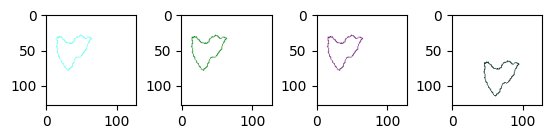

Different tasks in this dataset split: 
 ['task_pos']


Number of samples per task in this dataset split: 
 task
task_pos    500
Name: count, dtype: int64


In [29]:
dataset_train_path = "./final_datasets/sample-efficiency/exp_setting_1/experiment_2/train.csv"
check_CVR_dataloader(dataset_train_path)
get_tasks_info(dataset_train_path)

Creating a torch Dataset and DataLoader for images of size 128
Batch is of type:  <class 'list'>
Batch:  [tensor([[[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]],


         [[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1

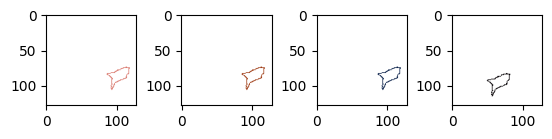

Different tasks in this dataset split: 
 ['task_pos']


Number of samples per task in this dataset split: 
 task
task_pos    1000
Name: count, dtype: int64


In [30]:
dataset_test_path = "./final_datasets/sample-efficiency/exp_setting_1/experiment_2/test.csv"
check_CVR_dataloader(dataset_test_path)
get_tasks_info(dataset_test_path)

### Compositionality

In [31]:
random.seed(1997)
torch.manual_seed(1997)

In [32]:
study = "compositionality"

In [33]:
# ** Experiment setting 1: Composition from Elementary to Composite **
exp_setting_desc = """Experiment setting 1: Composition from Elementary to Composite"""

# We consider the elementary tasks: "task_pos", "task_rot", "task_count", "task_color"
# We consider the composite tasks: task_rot_rot_1, task_count_count, task_color_color_1, task_pos_rot_1, task_color_count_1, task_rot_count_1, task_rot_color, task_pos_pos_1, task_pos_color_1, task_pos_count_1
# We create train datasets of size N_train = 10000
# We create val datasets of size N_val = 500
# We create test datasets of size N_test = 1000

splits = ['train', 'val', 'test']
experiment_setting_base = {'index': "1", 'splits': splits}

elem_tasks = ["task_pos", "task_rot", "task_count", "task_color"]
comp_tasks = ["task_rot_rot_1", "task_count_count", "task_color_color_1", "task_pos_rot_1", "task_color_count_1", "task_rot_count_1", "task_rot_color", "task_pos_pos_1", "task_pos_color_1", "task_pos_count_1"]

elem_task_pairs_to_composite_tasks_matching = create_elem_task_pairs_to_composite_tasks_dict(elem_tasks, comp_tasks)
print(elem_task_pairs_to_composite_tasks_matching)

train_sizes = [10000]
val_sizes = [500] * len(train_sizes)
test_sizes = [1000] * len(train_sizes)

experiment_setting = {**experiment_setting_base, 
                      'elem_tasks': elem_tasks,
                      'comp_tasks': comp_tasks,
                      'elem_task_pairs_to_composite_tasks_matching': elem_task_pairs_to_composite_tasks_matching,
                      'train_sizes': train_sizes, 
                      'val_sizes': val_sizes, 
                      'test_sizes': test_sizes,
                      'desc': exp_setting_desc
                      }

create_dataset(metadata_dataset_path, compositionality_dir, study, experiment_setting)

Elementary tasks considered:  ['task_pos', 'task_rot', 'task_count', 'task_color']
Composite tasks considered:  ['task_rot_rot_1', 'task_count_count', 'task_color_color_1', 'task_pos_rot_1', 'task_color_count_1', 'task_rot_count_1', 'task_rot_color', 'task_pos_pos_1', 'task_pos_color_1', 'task_pos_count_1']
{('task_rot', 'task_rot'): 'rot_rot_1', ('task_count', 'task_count'): 'count_count', ('task_color', 'task_color'): 'color_color_1', ('task_pos', 'task_rot'): 'pos_rot_1', ('task_count', 'task_color'): 'color_count_1', ('task_rot', 'task_count'): 'rot_count_1', ('task_rot', 'task_color'): 'rot_color', ('task_pos', 'task_pos'): 'pos_pos_1', ('task_pos', 'task_color'): 'pos_color_1', ('task_pos', 'task_count'): 'pos_count_1'}
Created path experiment setting:  ./final_datasets/compositionality/exp_setting_1
KEYS:  dict_keys(['index', 'splits', 'elem_tasks', 'comp_tasks', 'elem_task_pairs_to_composite_tasks_matching', 'train_sizes', 'val_sizes', 'test_sizes', 'desc'])
Type of experiment_

Creating a torch Dataset and DataLoader for images of size 128
Batch is of type:  <class 'list'>
Batch:  [tensor([[[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]],


         [[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1

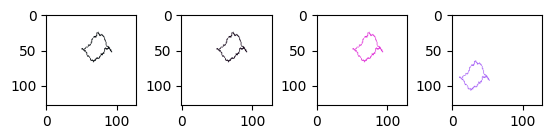

Different tasks in this dataset split: 
 ['task_pos' 'task_rot']


Number of samples per task in this dataset split: 
 task
task_pos    5000
task_rot    5000
Name: count, dtype: int64


In [34]:
dataset_train_path = "./final_datasets/compositionality/exp_setting_1/experiment_2/train.csv"
check_CVR_dataloader(dataset_train_path)
get_tasks_info(dataset_train_path)

Creating a torch Dataset and DataLoader for images of size 128
Batch is of type:  <class 'list'>
Batch:  [tensor([[[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]],


         [[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1

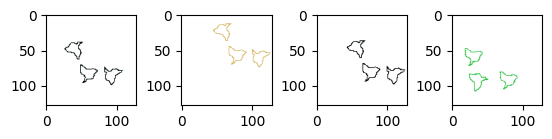

Different tasks in this dataset split: 
 ['task_pos_rot_1']


Number of samples per task in this dataset split: 
 task
task_pos_rot_1    1000
Name: count, dtype: int64


In [35]:
dataset_test_path = "./final_datasets/compositionality/exp_setting_1/experiment_2/test.csv"
check_CVR_dataloader(dataset_test_path)
get_tasks_info(dataset_test_path)


In [36]:
# ** Experiment setting 2: Decomposition from Composite to Elementary **
exp_setting_desc = """Experiment setting 2: Decomposition from Composite to Elementary"""

# We consider the elementary tasks: "task_pos", "task_rot", "task_count", "task_color"
# We consider the composite tasks: task_rot_rot_1, task_count_count, task_color_color_1, task_pos_rot_1, task_color_count_1, task_rot_count_1, task_rot_color, task_pos_pos_1, task_pos_color_1, task_pos_count_1
# We create train datasets of size N_train = 10000
# We create val datasets of size N_val = 500
# We create test datasets of size N_test = 1000

splits = ['train', 'val', 'test']
experiment_setting_base = {'index': "2", 'splits': splits}

elem_tasks = ["task_pos", "task_rot", "task_count", "task_color"]
comp_tasks = ["task_rot_rot_1", "task_count_count", "task_color_color_1", "task_pos_rot_1", "task_color_count_1", "task_rot_count_1", "task_rot_color", "task_pos_pos_1", "task_pos_color_1", "task_pos_count_1"]

elem_task_pairs_to_composite_tasks_matching = create_elem_task_pairs_to_composite_tasks_dict(elem_tasks, comp_tasks)
print(elem_task_pairs_to_composite_tasks_matching)

train_sizes = [10000]
val_sizes = [500] * len(train_sizes)
test_sizes = [1000] * len(train_sizes)

experiment_setting = {**experiment_setting_base, 
                      'elem_tasks': elem_tasks,
                      'comp_tasks': comp_tasks,
                      'elem_task_pairs_to_composite_tasks_matching': elem_task_pairs_to_composite_tasks_matching,
                      'train_sizes': train_sizes,
                      'val_sizes': val_sizes, 
                      'test_sizes': test_sizes,
                      'desc': exp_setting_desc
                      }

create_dataset(metadata_dataset_path, compositionality_dir, study, experiment_setting)

Elementary tasks considered:  ['task_pos', 'task_rot', 'task_count', 'task_color']
Composite tasks considered:  ['task_rot_rot_1', 'task_count_count', 'task_color_color_1', 'task_pos_rot_1', 'task_color_count_1', 'task_rot_count_1', 'task_rot_color', 'task_pos_pos_1', 'task_pos_color_1', 'task_pos_count_1']
{('task_rot', 'task_rot'): 'rot_rot_1', ('task_count', 'task_count'): 'count_count', ('task_color', 'task_color'): 'color_color_1', ('task_pos', 'task_rot'): 'pos_rot_1', ('task_count', 'task_color'): 'color_count_1', ('task_rot', 'task_count'): 'rot_count_1', ('task_rot', 'task_color'): 'rot_color', ('task_pos', 'task_pos'): 'pos_pos_1', ('task_pos', 'task_color'): 'pos_color_1', ('task_pos', 'task_count'): 'pos_count_1'}
Created path experiment setting:  ./final_datasets/compositionality/exp_setting_2
Created path experiment:  ./final_datasets/compositionality/exp_setting_2/experiment_1
New dataset created at: ./final_datasets/compositionality/exp_setting_2/experiment_1/train.csv


Creating a torch Dataset and DataLoader for images of size 128
Batch is of type:  <class 'list'>
Batch:  [tensor([[[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]],


         [[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1

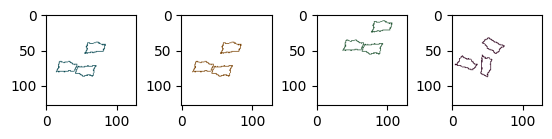

Different tasks in this dataset split: 
 ['task_pos_rot_1']


Number of samples per task in this dataset split: 
 task
task_pos_rot_1    10000
Name: count, dtype: int64


In [37]:
dataset_train_path = "./final_datasets/compositionality/exp_setting_2/experiment_2/train.csv"
check_CVR_dataloader(dataset_train_path)
get_tasks_info(dataset_train_path)

Creating a torch Dataset and DataLoader for images of size 128
Batch is of type:  <class 'list'>
Batch:  [tensor([[[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]],


         [[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1

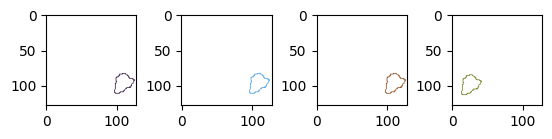

Different tasks in this dataset split: 
 ['task_pos' 'task_rot']


Number of samples per task in this dataset split: 
 task
task_pos    500
task_rot    500
Name: count, dtype: int64


In [38]:
dataset_testt_path = "./final_datasets/compositionality/exp_setting_2/experiment_2/test.csv"
check_CVR_dataloader(dataset_testt_path)
get_tasks_info(dataset_testt_path)

In [39]:
# ** Experiment setting 3: From Composite to Unseen Composite **

exp_setting_desc = """Experiment setting 3: From Composite to Unseen Composite"""

# We consider the composite tasks: task_rot_rot_1, task_count_count, task_color_color_1, task_pos_rot_1, task_color_count_1, task_rot_count_1, task_rot_color, task_pos_pos_1, task_pos_color_1, task_pos_count_1
# We create train datasets of size N_train = 10000
# We create val datasets of size N_val = 500
# We create test datasets of size N_test = 1000

splits = ['train', 'val', 'test']
experiment_setting_base = {'index': "3", 'splits': splits}

comp_tasks = ["task_rot_rot_1", "task_count_count", "task_color_color_1", "task_pos_rot_1", "task_color_count_1", "task_rot_count_1", "task_rot_color", "task_pos_pos_1", "task_pos_color_1", "task_pos_count_1"]

train_sizes = [10000]
val_sizes = [500] * len(train_sizes)
test_sizes = [1000] * len(train_sizes)

experiment_setting = {**experiment_setting_base, 
                      'comp_tasks': comp_tasks,
                      'train_sizes': train_sizes, 
                      'val_sizes': val_sizes, 
                      'test_sizes': test_sizes,
                      'desc': exp_setting_desc
                      }

create_dataset(metadata_dataset_path, compositionality_dir, study, experiment_setting)

Created path experiment setting:  ./final_datasets/compositionality/exp_setting_3
Created path experiment:  ./final_datasets/compositionality/exp_setting_3/experiment_1
New dataset created at: ./final_datasets/compositionality/exp_setting_3/experiment_1/train.csv
New dataset created at: ./final_datasets/compositionality/exp_setting_3/experiment_1/val.csv
New dataset created at: ./final_datasets/compositionality/exp_setting_3/experiment_1/test.csv
Metadata about the created experiment dataset saved at: ./final_datasets/compositionality/exp_setting_3/experiment_1/dataset_metadata.json
Created path experiment:  ./final_datasets/compositionality/exp_setting_3/experiment_2
New dataset created at: ./final_datasets/compositionality/exp_setting_3/experiment_2/train.csv
New dataset created at: ./final_datasets/compositionality/exp_setting_3/experiment_2/val.csv
New dataset created at: ./final_datasets/compositionality/exp_setting_3/experiment_2/test.csv
Metadata about the created experiment dat

Creating a torch Dataset and DataLoader for images of size 128
Batch is of type:  <class 'list'>
Batch:  [tensor([[[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]],


         [[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1

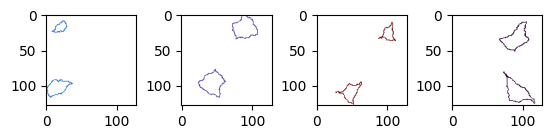

Different tasks in this dataset split: 
 ['task_rot_rot_1' 'task_color_color_1' 'task_pos_rot_1'
 'task_color_count_1' 'task_rot_count_1' 'task_rot_color' 'task_pos_pos_1'
 'task_pos_count_1']


Number of samples per task in this dataset split: 
 task
task_rot_rot_1        1111
task_color_color_1    1111
task_pos_rot_1        1111
task_color_count_1    1111
task_rot_count_1      1111
task_rot_color        1111
task_pos_pos_1        1111
task_pos_count_1      1111
Name: count, dtype: int64


In [40]:
dataset_train_path = "./final_datasets/compositionality/exp_setting_3/experiment_2/train.csv"
check_CVR_dataloader(dataset_train_path)
get_tasks_info(dataset_train_path)

Creating a torch Dataset and DataLoader for images of size 128
Batch is of type:  <class 'list'>
Batch:  [tensor([[[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]],


         [[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1

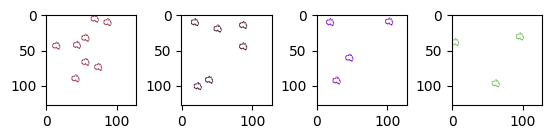

Different tasks in this dataset split: 
 ['task_count_count']


Number of samples per task in this dataset split: 
 task
task_count_count    1000
Name: count, dtype: int64


In [41]:
dataset_test_path = "./final_datasets/compositionality/exp_setting_3/experiment_2/test.csv"
check_CVR_dataloader(dataset_test_path)
get_tasks_info(dataset_test_path)

### Systematic Generalization

In [42]:
random.seed(1997)
torch.manual_seed(1997)

In [43]:
study = "sys-gen"

In [44]:
# ** Experiment setting 1: Various Parameters Randomness Difficulty **

exp_setting_desc = """Experiment setting 1: Various Parameters Randomness Difficulty"""

# We consider the elementary tasks "task_pos" and "task_rot"
# We create train datasets of size N_train = 5000
# We create val datasets of size N_val = 500
# We create test datasets of size N_test = 1000
# We create test_gen datasets of size N_test_gen = 1000

splits = ['train', 'val', 'test', 'test_gen']
experiment_setting_base = {'index': "1", 'splits': splits}

elem_tasks = ["task_pos", "task_rot"]

train_sizes = [5000]
val_sizes = [500] * len(train_sizes)
test_sizes = [1000] * len(train_sizes)
test_gen_sizes = [1000] * len(train_sizes)

experiment_setting = {**experiment_setting_base, 
                      'elem_tasks': elem_tasks, 
                      'train_sizes': train_sizes, 
                      'val_sizes': val_sizes, 
                      'test_sizes': test_sizes,
                      'test_gen_sizes': test_gen_sizes,
                      'desc': exp_setting_desc
                      }

create_dataset(metadata_dataset_path, sys_gen_dir, study, experiment_setting)


Created path experiment setting:  ./final_datasets/sys-gen/exp_setting_1
Created path experiment:  ./final_datasets/sys-gen/exp_setting_1/experiment_1
New dataset created at: ./final_datasets/sys-gen/exp_setting_1/experiment_1/train.csv
New dataset created at: ./final_datasets/sys-gen/exp_setting_1/experiment_1/val.csv
New dataset created at: ./final_datasets/sys-gen/exp_setting_1/experiment_1/test.csv
New dataset created at: ./final_datasets/sys-gen/exp_setting_1/experiment_1/test_gen.csv
Metadata about the created experiment dataset saved at: ./final_datasets/sys-gen/exp_setting_1/experiment_1/dataset_metadata.json
Created path experiment:  ./final_datasets/sys-gen/exp_setting_1/experiment_2
New dataset created at: ./final_datasets/sys-gen/exp_setting_1/experiment_2/train.csv
New dataset created at: ./final_datasets/sys-gen/exp_setting_1/experiment_2/val.csv
New dataset created at: ./final_datasets/sys-gen/exp_setting_1/experiment_2/test.csv
New dataset created at: ./final_datasets/s

Creating a torch Dataset and DataLoader for images of size 128
Batch is of type:  <class 'list'>
Batch:  [tensor([[[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]],


         [[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1

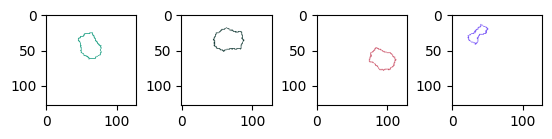

Different tasks in this dataset split: 
 ['task_rot']


Number of samples per task in this dataset split: 
 task
task_rot    5000
Name: count, dtype: int64


In [45]:
dataset_train_path = "./final_datasets/sys-gen/exp_setting_1/experiment_2/train.csv"
check_CVR_dataloader(dataset_train_path)
get_tasks_info(dataset_train_path)

Creating a torch Dataset and DataLoader for images of size 128
Batch is of type:  <class 'list'>
Batch:  [tensor([[[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],

          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]],


         [[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1

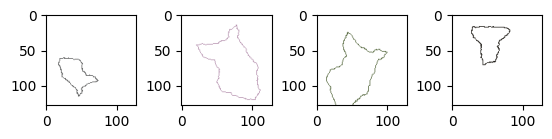

Different tasks in this dataset split: 
 ['task_rot']


Number of samples per task in this dataset split: 
 task
task_rot    1000
Name: count, dtype: int64


In [46]:
dataset_test_path = "./final_datasets/sys-gen/exp_setting_1/experiment_2/test_gen.csv"
check_CVR_dataloader(dataset_test_path)
get_tasks_info(dataset_test_path)
